# Model Exploration

In this notebook, we plot the RGB, DSM, and DTM data side by side, and layer the ground-truth mask as well as the predicted mask over the RGB data. We also present the accuracy metrics of the model on the RGB + DSM/DTM data.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'axes.grid':False})
import numpy as np
import torch, cv2, gdal, georaster
import sys, os, json, math
from pytorch_utils.eval import read_model, flip
from nbutils import thresh, score_pred, load_img, make_input_tensor, predict_on_file, get_saliency_big, plot_poly
from config import Config
from tqdm import tqdm
%matplotlib inline

To avoid excessive warning information and `print`ed information from georaster, we redirect stdout to trash

In [2]:
import sys

In [3]:
jupyter_out = sys.stderr, sys.stdout
trash = open('/dev/null', 'w')

def ctrl_output(show=False):
    info = (trash, trash)
    if show:
        info = jupyter_out
    sys.stderr, sys.stdout = info

Here we are going to use the model trained only on RGB data.

In [4]:
cfg_f = '../resnet34_1x1080_retrain_RGB.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
cfg = Config(**cfg)
model = read_model(cfg, 3)

### Examine the Satellite Imagery and Depth Mapping

We are loading in a random image

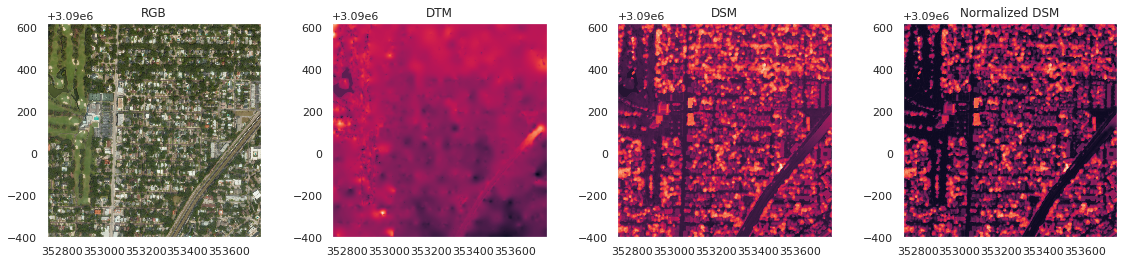

In [18]:
fname = '../../Train/Inputs/TAM_Tile_099_RGB.tif'
dsmname = fname.replace('RGB', 'DSM')
dtmname = fname.replace('RGB', 'DTM')
img = load_img(fname, tiff=False)
fig, axes = plt.subplots(ncols=4, figsize=(16,8))
geo_img = georaster.MultiBandRaster(fname, load_data=False)
dtm_img = georaster.SingleBandRaster(dtmname).r
dsm_img = georaster.SingleBandRaster(dsmname).r
dem_img = (dsm_img - dtm_img) / 9.0
axes[0].imshow(img, extent=geo_img.extent)
axes[0].set_title("RGB")
axes[1].imshow(dtm_img, extent=geo_img.extent)
axes[1].set_title("DTM")
axes[2].imshow(dsm_img, extent=geo_img.extent)
axes[2].set_title("DSM")
axes[3].imshow(dem_img, extent=geo_img.extent)
axes[3].set_title("Normalized DSM")
fig.tight_layout()
# fig.savefig('Satellite+Depth.png', dpi=200)

### Create Polygons from Ground Truth Labels

63 0 0.5931944847106934


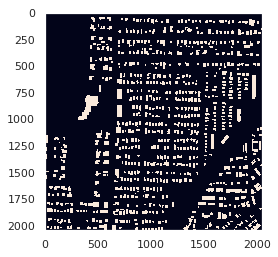

In [20]:
lblname='../../Train/GT/TAM_Tile_099_GTL.tif'
geo_lbl = georaster.SingleBandRaster(lblname)
lbl = geo_lbl.r - 2
plt.imshow(lbl, extent=geo_lbl.extent)
print(lbl.max(), lbl.min(), lbl.mean())
retval, dst = cv2.threshold(lbl, 0.5, maxval=lbl.max(), type=0)
_ = plt.imshow(dst)

### Combining the Satellite Imagery with Polygon Labels

Here we develop some tools that will plot ground truth & predicted polygon labels. In the following portions, we will develop the ability to predict using the model.

In [13]:
TRUE_COLOR = (0, 0.2, 0.9, 0.6)
PRED_COLOR = (0, 0.9, 0, 0.4)

#### Predicting with the pretrained model

We replicate a few ensembling and averaging techniques traditionally used to improve ensemble accuracy, however, there we are still missing some of the subtlety to Albu's solution. Albu trains 5 models on 5 different folds of the dataset, and ensembles their predictions on the flips. We, however, are only using 1 model from the last of the 5 folds. Here we use window-crops.

It's worth noting that the accuracy differs between these different methods. In theory, I don't think there should be this much variation, but I don't have that much experience in this yet.

In [21]:
ctrl_output(False)
output = predict_on_file(model, fname, crop=True, channels=3)
z1 = score_pred(thresh(output),lbl)
z2 = score_pred(thresh(predict_on_file(model, fname, crop=False, channels=3)), lbl)
z3 = score_pred(thresh(predict_on_file(model, fname, crop=False, 
                                       flips=flip.FLIP_NONE, channels=3)), lbl)
ctrl_output(True)
print("F1 / IOU with crop + flip:", z1)
print("F1 / IOU with no crop + flip:", z2)
print("F1 / IOU with no crop + no flip:", z3)

F1 / IOU with crop + flip: 0.8130991663947075
F1 / IOU with no crop + flip: 0.8135884226626042
F1 / IOU with no crop + no flip: 0.8151775217399319


## Comparing Predicted with Ground Truth

The blue represents the ground truth, and the yellow-green represents the predicted solutions from cropping & flipping with Albu's model from the last fold of the dataset.

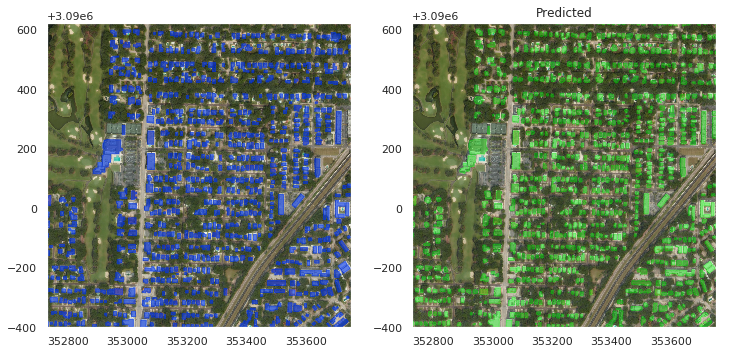

In [16]:
get_ctr = lambda out: cv2.findContours(cv2.threshold(out, 127, 255, 0)[1], 
                                           cv2.RETR_TREE,
                                           cv2.CHAIN_APPROX_SIMPLE)[1]
fig, ax = plt.subplots(figsize=(12, 6), ncols=2)
ax[0].imshow(img, extent=geo_img.extent)
plot_poly(get_ctr(lbl*255), ax[0], geo_img.coordinates, TRUE_COLOR)
ax[1].imshow(img, extent=geo_img.extent)
ax[1].set_title("Predicted")

plot_poly(get_ctr(output), ax[1], geo_img.coordinates, PRED_COLOR)

Right so this is old news. Now we want to actually check if this works on SpaceNet

In [13]:
def load_tiff(fname):
    tiff = gdal.Open(fname, gdal.GA_ReadOnly)
    arr = [tiff.GetRasterBand(idx).ReadAsArray() for idx in range(1, tiff.RasterCount+1)]
    return np.dstack(arr)

def standardize(x):
    return x / (2047)

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent=1):
    """Colorbalances images
    taken from: https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc"""
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[int(math.floor(n_cols * half_percent))]
        high_val = flat[int(math.ceil( n_cols * (1.0 - half_percent)))]
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

def two_sig(img, factor=2):
    """Drop the data outside of 2 sig range. Returns data in [0, 1] range"""
    h, w, ch = img.shape
    out_channels = []
    for i in range(ch):
        c_img = img[:,:,i]
        mean = c_img.mean()
        std = c_img.std()
        # Calculate 2 std above
        c_img = np.where(c_img > mean + factor*std, mean + factor*std, c_img)
        c_img = np.where(c_img < mean - factor*std, mean - factor*std, c_img)
#         c_img = (c_img - mean + factor*std) / (2 * factor * std)
        c_img = cv2.normalize(c_img, c_img.copy(), 0, 1, cv2.NORM_MINMAX)
        out_channels.append(c_img)
    
    return cv2.merge(out_channels)

def reg_scale(img):
    m, l = img.max(), img.min()
    return (img - l) / (m - l) * 255

In [14]:
def proper_predict(img):
    """flips & shit
    note that the img(x) will prolly have to have a size of a power of 2"""
    avg = np.zeros(img.shape[:-1])
    for i in range(5):
        x = img
        model = read_model(cfg, i)
        x = torch.Tensor(np.transpose(x, (2, 0, 1))).unsqueeze(0).cuda()
        # Put imgs in [0, 1] range!
        x = x / 255.0
        ctrl_output(False)
        out = model(x).squeeze().data.cpu().numpy()
        ctrl_output(True)
        avg += out.astype(np.float32) / 5.0
    return avg

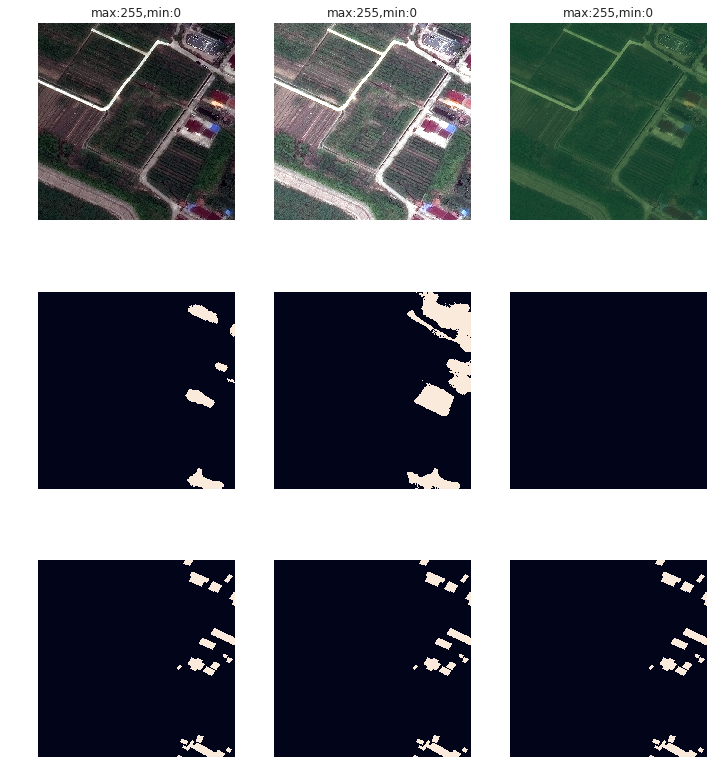

In [123]:
img_id = "img1007"

datadir = "/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/"
prefix="RGB-PanSharpen_AOI_4_Shanghai_"
suffix ='.tif'

shang = load_tiff(datadir+prefix+img_id+suffix)
lbldir = '/datasets/Shanghai/AOI_4_Shanghai_Train/Shanghai-Segs/'
prefix='buildings_AOI_4_Shanghai_'
suffix='.geojson.npy'
segs = np.load(lbldir + prefix + img_id + suffix)

balance = simplest_cb(shang)
sigma = two_sig(shang) * 255
# reg = reg_scale(shang)
reg = cv2.balance()
preds = []
for x in balance, sigma, reg:
    x = cv2.resize(x, (512, 512)).astype(np.uint8)
    out = proper_predict(x)
    out = thresh(out*255)
    preds.append(out)

fig, ax = plt.subplots(figsize=(12, 14), ncols=3, nrows=3)
for a in ax.ravel():
    a.axis("off")
    
for a, b in zip(ax[0], [balance, sigma, reg]):
    b = b.astype(np.uint8)
    a.imshow(b)
    a.set_title(f"max:{int(b.max())},min:{int(b.min())}")
for a, p in zip(ax[1], preds):
    a.imshow(p)
for a, s in zip(ax[2], [segs]*3):
    a.imshow(s)

### Finding examples with highest loss

In [209]:
datadir = "/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/"
iprefix="RGB-PanSharpen_AOI_4_Shanghai_"
isuffix ='.tif'

lbldir = '/datasets/Shanghai/AOI_4_Shanghai_Train/Shanghai-Segs/'
lprefix='buildings_AOI_4_Shanghai_'
lsuffix='.geojson.npy'

with open("shanghai-scores-RGB-only.csv", 'w') as f:
    score_max = 0
    for x in tqdm(os.listdir(datadir)):
        if x.endswith('tif'):
            img_id = x.strip(isuffix)[len(iprefix):]
            img = load_tiff(datadir + x)
            img = cv2.resize(simplest_cb(img), (512, 512)).astype(np.uint8)
            out = thresh(255*proper_predict(img))
            try:
                seg = np.load(lbldir + lprefix + img_id + lsuffix)
                seg = cv2.resize(seg, (512, 512))
                if np.mean(seg) <= 0:
                    score = 1 - np.mean(out / 255)
                else:
                    score = score_pred(out, seg)
                if score > score_max and seg.mean() > 0:
                    print("New Best F1 on {}: {}".format(img_id, score))
                    score_max = score
            except FileNotFoundError as e:
                print(e)
#                 score = "na"
#             f.write("{},{}\n".format(img_id,score))

  0%|          | 1/4582 [00:00<45:02,  1.70it/s]

New Best F1 on img4227: 0.36905049112528


  0%|          | 2/4582 [00:01<45:23,  1.68it/s]

New Best F1 on img1012: 0.702462980130791


  0%|          | 13/4582 [00:08<52:33,  1.45it/s]

New Best F1 on img3351: 0.7897422216293727


  2%|▏         | 69/4582 [00:50<56:04,  1.34it/s]  

New Best F1 on img190: 0.8165700008253487


  2%|▏         | 114/4582 [01:25<59:37,  1.25it/s] 

New Best F1 on img2231: 0.8836554052258048


  3%|▎         | 157/4582 [01:58<56:13,  1.31it/s]  

New Best F1 on img423: 0.9027155913115349


  4%|▍         | 178/4582 [02:14<59:40,  1.23it/s]  

New Best F1 on img1777: 0.9555255144538665


 12%|█▏        | 532/4582 [06:40<50:05,  1.35it/s]  

New Best F1 on img1094: 0.9814559783596597


 51%|█████     | 2314/4582 [28:36<26:43,  1.41it/s]

New Best F1 on img937: 0.9877908461753652


 78%|███████▊  | 3578/4582 [44:19<12:20,  1.36it/s]/home/ngundotra/.conda/envs/gdal/lib/python3.6/site-packages/scipy/spatial/distance.py:1311: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
100%|██████████| 4582/4582 [56:35<00:00,  1.46it/s]


In [154]:
print(score_max)

0.9877908461753652


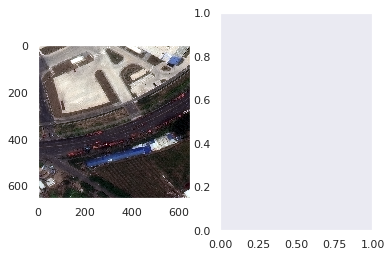

In [164]:
imgid='img2872'
arr = load_tiff(datadir+iprefix+imgid+isuffix)
fig, (left, right) = plt.subplots(ncols=2)
left.imshow(simplest_cb(arr))
# right.imshow(np.load(lbldir+lprefix+imgid+lsuffix))

### Redefining utilities to create labels to figure out why some plots don't have labels

In [192]:
from skimage.draw import polygon
def send2raster(raster, geom_coords, imgtiff, val=1):
    coords = np.array(geom_coords).squeeze()
    assert len(coords.shape)==2, "Coords.shape is off, coords = {}".format(coords.shape)
    coords = coords[:,:-1] # last column is all 0s
    xs, ys = imgtiff.coord_to_px(coords[:,0], coords[:,1], latlon=True)
    row, col = tune_coords(*polygon(xs, ys))
    raster[row, col] = val
    return tune_coords(xs, ys)

def tune_coords(xs, ys):
    """just transposes"""
    return ys, xs

messed_up = []
def create_raster(geojson, imgtiff, size=650):
    """Rasterizes a geojson file by using the coordinate system of the 
    corresponding GTiff"""
    with open(geojson,'r') as f:
        geo_info = json.load(f)

    raster = np.zeros((size, size))
    polys = []
    for i, bldg in enumerate(geo_info['features']):
        try:
            if bldg['geometry']['type'] == 'Polygon':
                xs, ys = send2raster(raster, bldg['geometry']['coordinates'], imgtiff)
                polys.append(np.vstack((xs, ys)).T)
            elif bldg['geometry']['type'] == 'MultiPolygon':
                for mat in bldg['geometry']['coordinates']:
                    xs, ys = send2raster(raster, mat, imgtiff)
                    polys.append(np.vstack((xs, ys)).T)
            else:
                raise ValueError('Unrecognized geometry type: {}'.format(bldg['geometry']['type']))
        except AssertionError as e:
            print("Assertion Error on file: {}".format(geojson))
            print(f"{bldg['geometry']['type']}")
            messed_up.append(geojson)
            print(e)
    return raster, polys

In [188]:
import pandas as pd

In [166]:
csv = pd.read_csv('shanghai-scores-RGB-only.csv')

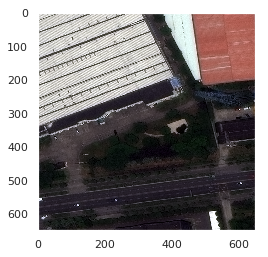

In [186]:
fs_not_found = csv[csv.iloc[:, 1] == 'na']
fs_not_found.columns = ['name', 'score']
plt.imshow(simplest_cb(load_tiff(datadir+iprefix+fs_not_found['name'].iloc[3]+isuffix)))

### This is just to clean up issues with label creation

In [204]:
gdir = '/datasets/Shanghai/AOI_4_Shanghai_Train/geojson/buildings/'
for gid in fs_not_found['name']:
    gprefix = lprefix
    gsuffix = '.geojson'
    tiff = georaster.MultiBandRaster(datadir+iprefix+gid+isuffix)
    ctrl_output(False)
    label, _ = create_raster(gdir+gprefix+gid+gsuffix, tiff)
    ctrl_output(True)
    np.save(lbldir+lprefix+gid+lsuffix, label)

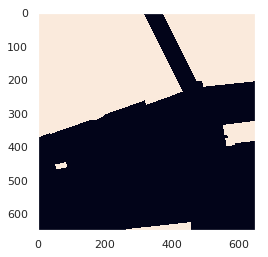

In [200]:
label, info = raster_info
plt.imshow(label)

# Testing the Model on CrowdAI
CrowdAI dataset

In [5]:
import skimage.io as io

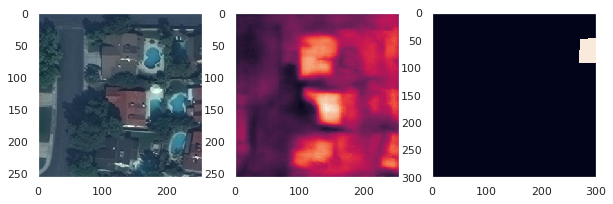

In [23]:
crowddir = '/datasets/CrowdAI/Train/images/'
crowdlbldir = '/datasets/CrowdAI/Train/labels/'
i_s = '.jpg'
l_s = '.npy'
random_fname = np.random.choice(os.listdir(crowddir))
crd_img = cv2.resize(io.imread(crowddir+random_fname), (256, 256))
crd_lbl = np.load(crowdlbldir+random_fname.replace(i_s, l_s))
crd_tensor = torch.Tensor(np.transpose(crd_img, axes=(2, 0, 1))).unsqueeze(0)

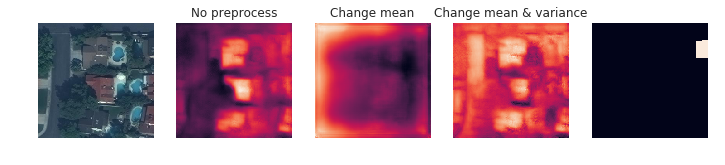

In [40]:
cmean = np.array([ 77.79408427, 89.68194542, 101.41694189])
cstd = np.array([[36.39705684, 33.36749231, 30.86501904]])
umean = np.array([[202.60747914, 204.23540725, 166.04711958]])
ustd = np.sqrt(np.array([5049.65872384, 4308.28606552, 4174.3828115]))
fig, ax = plt.subplots(figsize=(12, 6), ncols=5)
for a in ax:
    a.axis('off')
ax[0].imshow(crd_img)

p1 = proper_predict(crd_img)
ax[1].imshow(p1)
ax[1].set_title("No preprocess")

p2 = proper_predict((crd_img - crd_img.mean() + umean)
ax[2].imshow(p2)
ax[2].set_title("Change mean")

p3 = proper_predict((crd_img - crd_img.mean())/crd_img.std()*ustd + umean)
ax[3].imshow(p3)
ax[3].set_title("Change mean & variance")

ax[-1].imshow(crd_lbl)

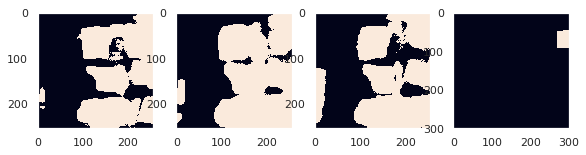

In [38]:
fig, ax = plt.subplots(figsize=(12, 8), ncols=5)
ax[0].set_visible(False)
for i, p in enumerate([p1, p2, p3]):
    ax[i+1].imshow(thresh(p - p.mean() + 127))
ax[-1].imshow(crd_lbl)

# Testing back on U3D

In [224]:
indir = '../../Train/Inputs/'
truthdir = '../../Train/GT/'

cfg_f = '../resnet34_1x1080_retrain.json'
with open(cfg_f, 'r') as f:
    cfg = json.load(f)
cfg = Config(**cfg)
sal_model = read_model(cfg, 4)

with open("urban3d-scores-RGB-only.csv", 'w') as f:
    score_max = 0
    for x in tqdm(os.listdir(indir)):
        if 'RGB' in x:
            img = load_tiff(indir + x)
            img = img / 255.0
            sal = np.load(indir + x.replace("RGB.tif", "SAL.npy"))
            model_in = [img[...,i] for i in range(3)] + [sal]
            assert len(model_in) == 4, f"{len(model_in)}"
            model_in = np.dstack(model_in)
            out = thresh(255*proper_predict(model_in))
            try:
                seg = georaster.SingleBandRaster(truthdir + x.replace("RGB", "GTL")).r - 2
                if np.mean(seg) <= 0:
                    score = 1 - np.mean(out / 255)
                else:
                    score = score_pred(out, seg)
                if score > score_max and seg.mean() > 0:
                    print("New Best F1 on {}: {}".format(img_id, score))
                    score_max = score
            except FileNotFoundError as e:
                print(e)
                score = "na"
            f.write("{},{}\n".format(img_id,score))

  0%|          | 0/697 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 512.00 MiB (GPU 0; 7.92 GiB total capacity; 6.26 GiB already allocated; 336.38 MiB free; 30.50 MiB cached)